In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nuscenes import NuScenes
from aggregate_nuscenes import (
    get_nuscenes_infos,
    aggregate_nuscenes_sequence,
    load_nuscenes_aggregated_points
)

/home/c276huan/LiDAR-UDA/completion_uda/tools/aggregation/aggregate_nuscenes.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
dataset_path = '../../data/nuscenes'
output_path = '../../data/nuscenes_agg'
nusc = NuScenes(version='v1.0-trainval', dataroot=dataset_path)
infos = get_nuscenes_infos( nusc )

Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
34149 panoptic,
Done loading in 52.757 seconds.
Reverse indexing ...
Done reverse indexing in 16.3 seconds.


In [ ]:
bg_points, obj_points = aggregate_nuscenes_sequence( nusc, infos, nusc.scene[0] )
bg_points = bg_points[np.random.choice(bg_points.shape[0], size=int(bg_points.shape[0]//32), replace=False)]

plt.figure(figsize=(12,12))
plt.scatter(-bg_points[:,1], bg_points[:,0], s=1000/bg_points.shape[0], alpha=0.5)
plt.show()
plt.close()

for token, obj_points_i in obj_points.items():
    obj_points_i = obj_points_i[np.random.choice(obj_points_i.shape[0], size=int(obj_points_i.shape[0]//32), replace=False)]
    obj_points_i[:,:3] -= obj_points_i[:,:3].mean(0)
    lim = np.abs(obj_points_i[:,:3]).max()
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        obj_points_i[:,0], obj_points_i[:,1], obj_points_i[:,2],
        c=obj_points_i[:,3],
        s=10000/obj_points_i.shape[0], 
        alpha=0.5
    )
    ax.set_xlim((-lim, lim))
    ax.set_ylim((-lim, lim))
    ax.set_zlim((-lim*0.75, lim*0.75))
    # plt.title(f'{token} - {category}')
    plt.show()
    plt.close()
    
    sns.jointplot(
        x=obj_points_i[:,0], y=obj_points_i[:,1],
        s=10000/obj_points_i.shape[0]
    )
    plt.show()
    plt.close()

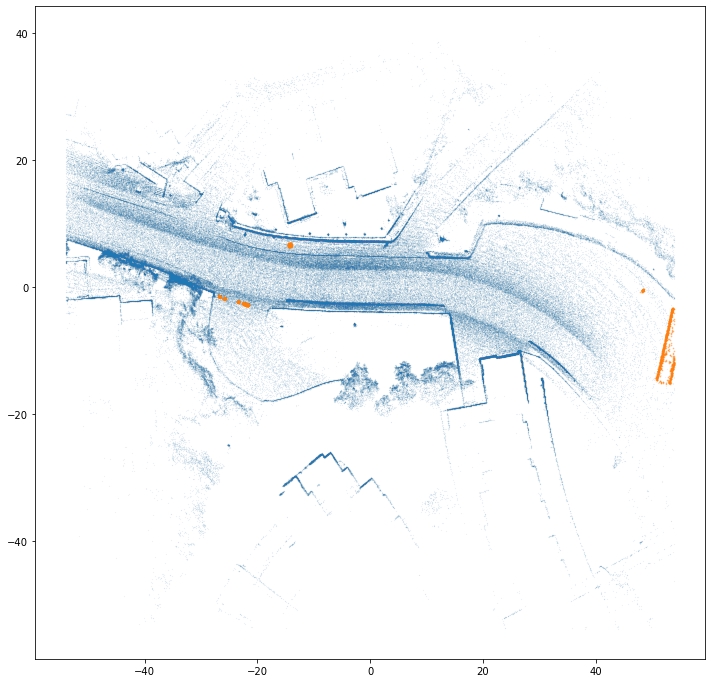

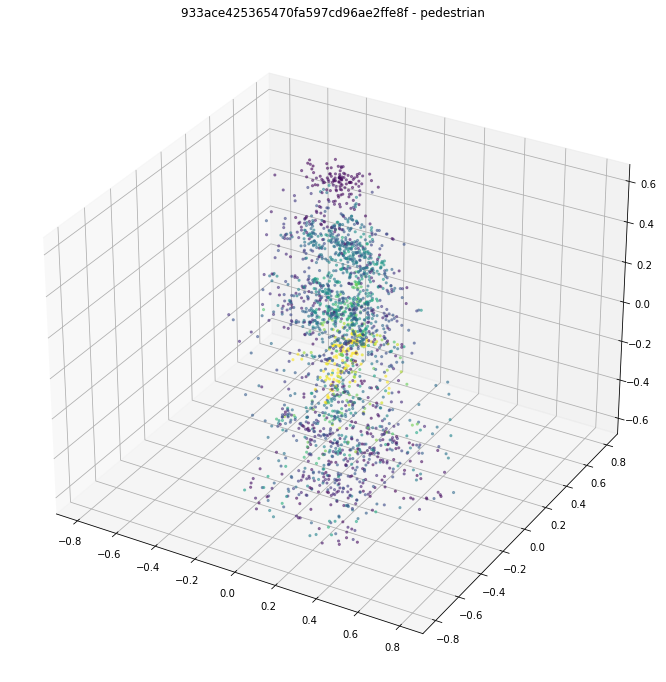

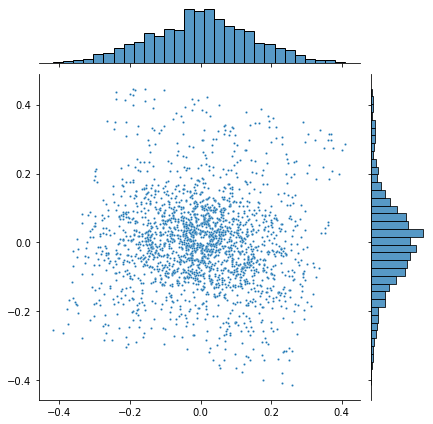

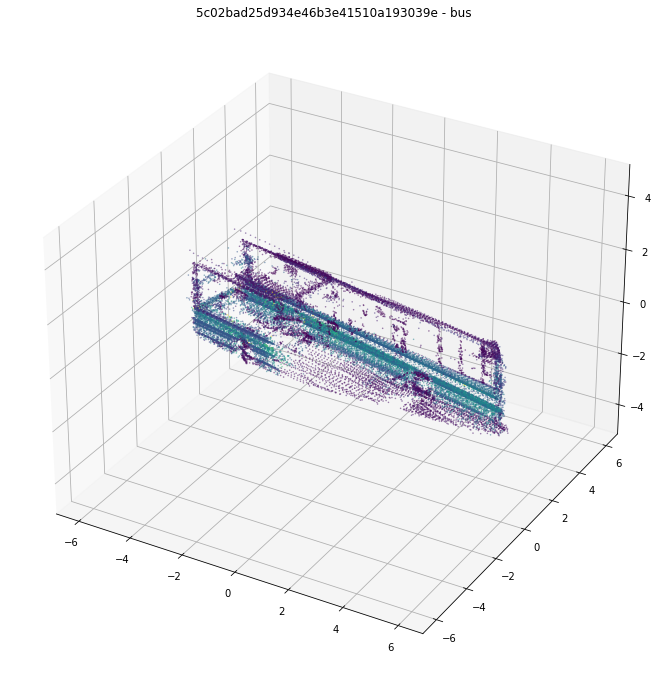

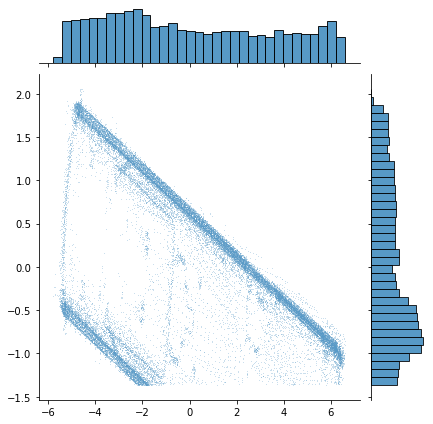

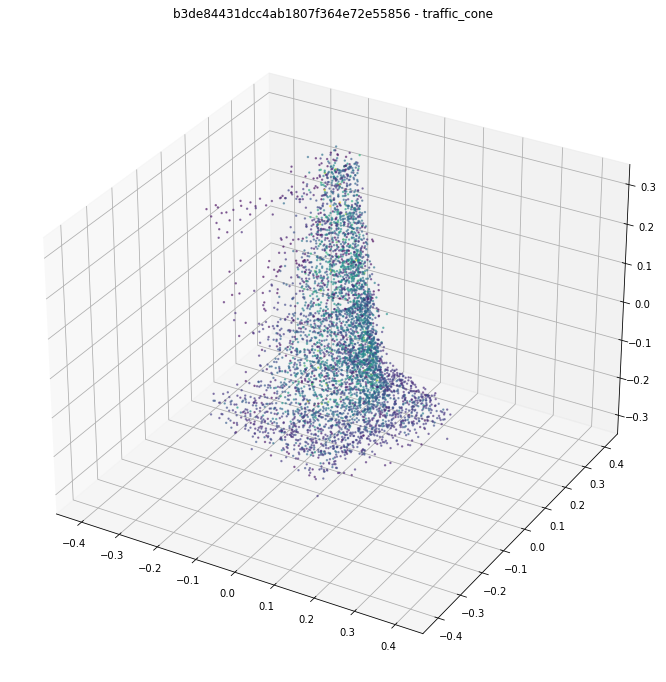

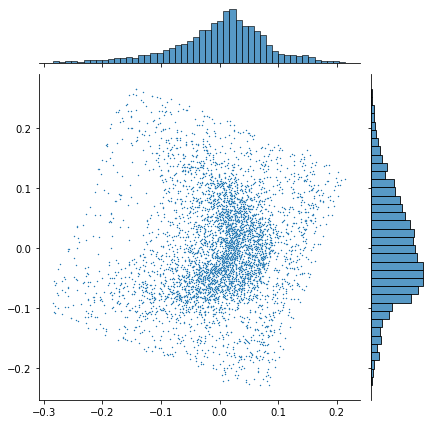

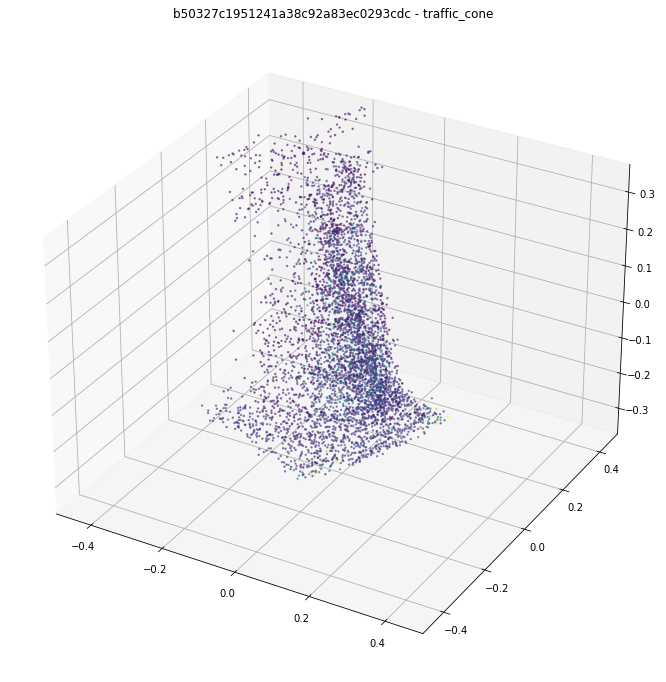

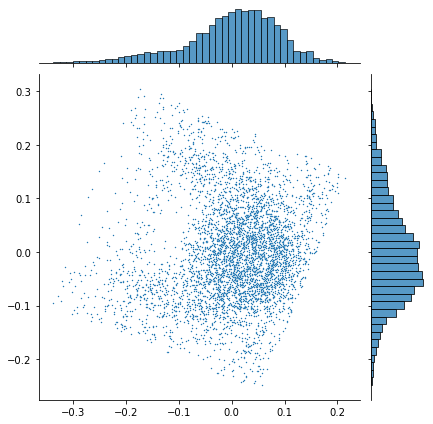

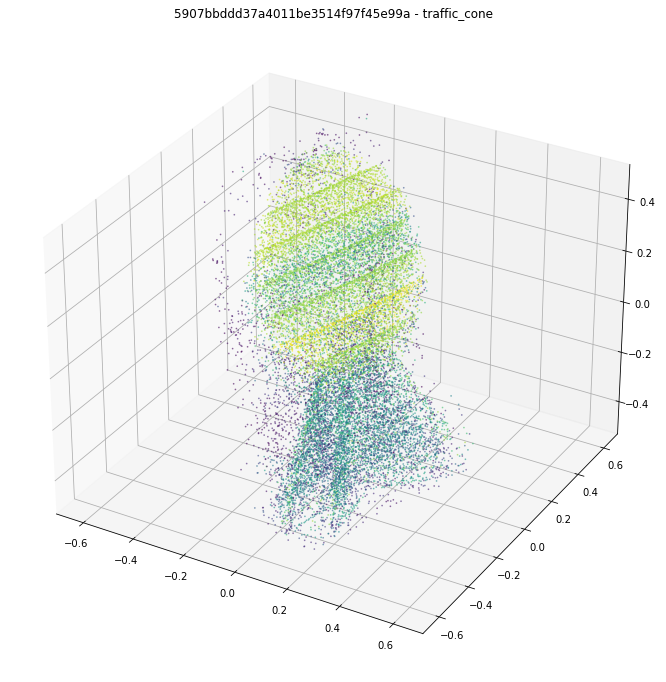

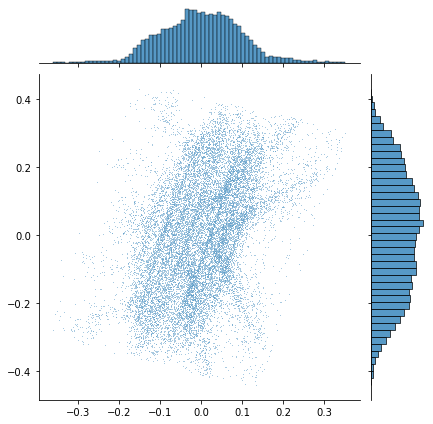

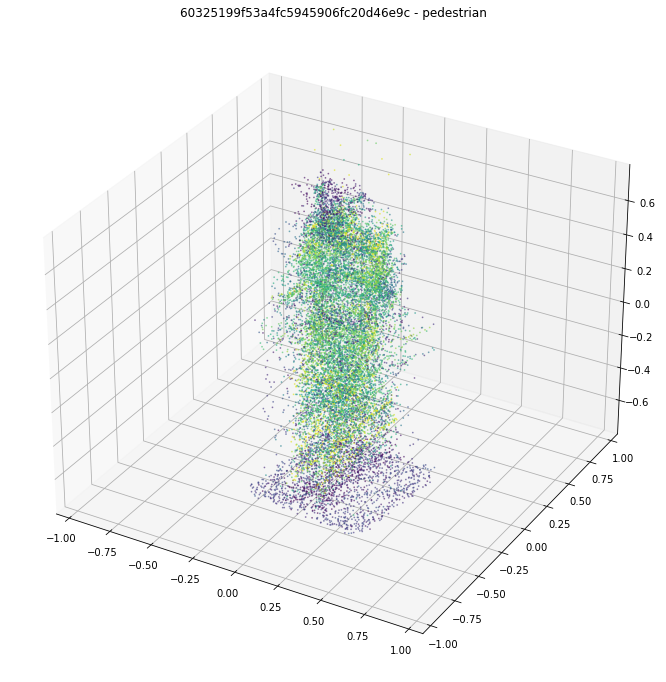

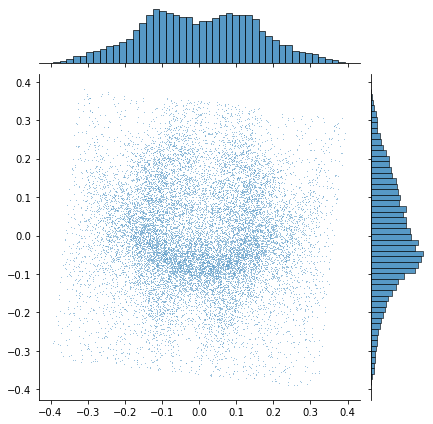

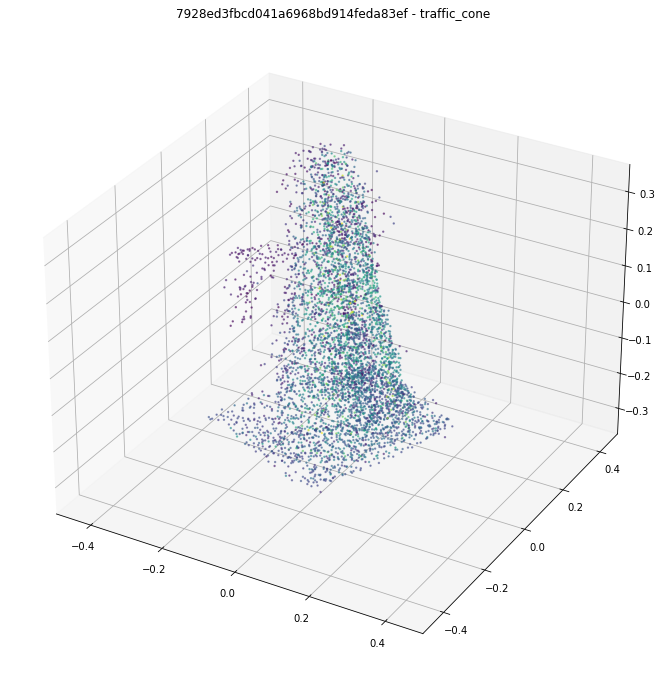

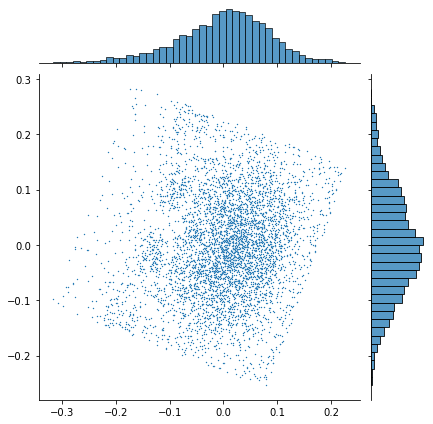

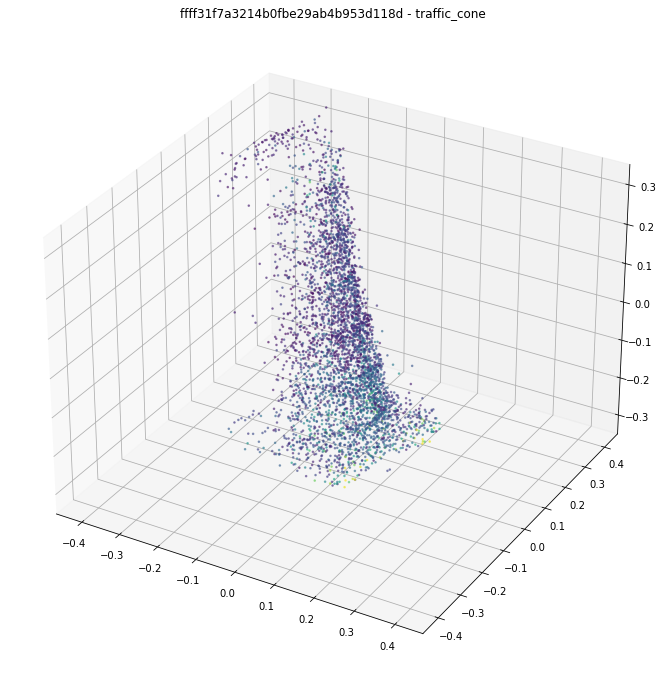

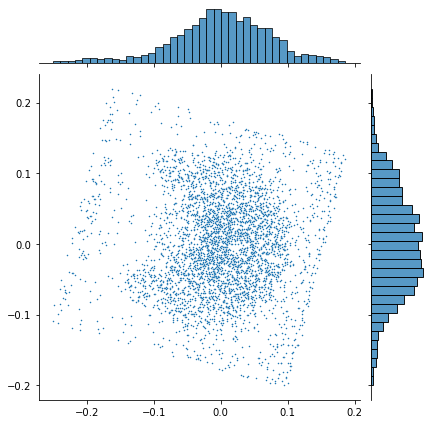

In [12]:
info = list(infos.values())[0]
bg_points, obj_points = load_nuscenes_aggregated_points( output_path, info )
obj_points_all = np.concatenate(list(obj_points.values()))

# Subsample
bg_points = bg_points[np.random.choice(bg_points.shape[0], size=int(bg_points.shape[0]//32), replace=False)]
obj_points_all = obj_points_all[np.random.choice(obj_points_all.shape[0], size=int(obj_points_all.shape[0]//32), replace=False)]

plt.figure(figsize=(12,12))
plt.scatter(-bg_points[:,1], bg_points[:,0], s=1000/bg_points.shape[0], alpha=0.5)
plt.scatter(-obj_points_all[:,1], obj_points_all[:,0], s=1000/obj_points_all.shape[0], alpha=0.5)
plt.show()
plt.close()

for category, (token, obj_points_i) in zip(info['gt_names'], obj_points.items()):
    if obj_points_i.shape[0] < 1000:
        continue

#     # Number of points in halves
#     y = obj_points_i[:,1]
#     if np.abs((y > 0).sum() - (y < 0).sum()) / y.shape[0] > 0.3:
#         continue
    
    obj_points_i[:,:3] -= obj_points_i[:,:3].mean(0)
    lim = np.abs(obj_points_i[:,:3]).max()
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        obj_points_i[:,0], obj_points_i[:,1], obj_points_i[:,2],
        c=obj_points_i[:,3],
        s=10000/obj_points_i.shape[0], 
        alpha=0.5
    )
    ax.set_xlim((-lim, lim))
    ax.set_ylim((-lim, lim))
    ax.set_zlim((-lim*0.75, lim*0.75))
    plt.title(f'{token} - {category}')
    plt.show()
    plt.close()
    
    sns.jointplot(
        x=obj_points_i[:,0], y=obj_points_i[:,1],
        s=10000/obj_points_i.shape[0]
    )
    plt.show()
    plt.close()

In [ ]:
!pip install websockets

In [ ]:
from vis3d import (
    Vis3DManager,
    PointCloud,
    Box
)

In [ ]:
# Starting a vis3d server
vis3d = Vis3DManager(port=2114)
await vis3d.serve()

In [ ]:
vis3d.objects = dict()
await vis3d.sync()

rt_bg = np.log(bg_points[:,3]+1)  # Point cloud intensity (log)
rt_bg = rt_bg / rt_bg.max()           # normalize intensity
pc_bg = PointCloud(
    bg_points[:,:3],                   # Point cloud numpy array: (# of points, 3)
    color=plt.get_cmap('viridis')(rt_bg),  # Colors
    name='Background'                      # A name
)
await vis3d.add(pc_bg)                     # Add point cloud to visualizer

rt_fg = np.log(obj_points_all[:,3]+1)
rt_fg = rt_fg / rt_fg.max()
pc_fg = PointCloud(
    obj_points_all[:,:3],
    color=plt.get_cmap('inferno')(rt_fg),
    name='Foreground'
)
await vis3d.add(pc_fg)

# for i, (instance_token, box) in enumerate(boxes[frame_idx].items()):
#     instance = nusc.get('instance', instance_token)
#     category = nusc.get('category', instance['category_token'])['name']
#     box_vis = Box(data=box, color='red', name=f'{category} ({box[0]:.0f},{box[1]:.0f})')
#     await vis3d.add(box_vis)          # Add box to visualizer